In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import subprocess as sp
import geopandas as gpd
from odc.io.cgroups import get_cpu_quota
from odc.geo.xr import assign_crs
import pandas as pd

from deafrica_tools.plotting import map_shapefile
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import collect_training_data


# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier

import os
import sys
import joblib
import numpy as np
import pandas as pd
from joblib import dump
import subprocess as sp
import dask.array as da
from pprint import pprint
import matplotlib.pyplot as plt
from odc.io.cgroups import get_cpu_quota
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, f1_score


%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
path = 'lamu_mangrove.geojson' 
field = 'class'

In [3]:
ncpus=round(get_cpu_quota())
print('ncpus = '+str(ncpus))

ncpus = 2


In [4]:
# Load input data shapefile
input_data = gpd.read_file(path)

# Transform the class column datatype to int.
input_data[field] = input_data[field].astype(int)

# Plot first five rows
input_data.head()

,id,class,geometry
0,1,1,"MULTIPOLYGON (((-0.27665 39.25044, -0.31721 39..."
1,2,0,"MULTIPOLYGON (((-0.59857 39.57489, -0.61884 39..."
2,3,0,"MULTIPOLYGON (((-0.26651 39.66867, -0.33242 39..."
3,4,1,"MULTIPOLYGON (((-0.33084 39.46235, -0.33149 39..."
4,5,1,"MULTIPOLYGON (((-0.21966 39.65611, -0.22356 39..."


In [5]:
# Plot training data in an interactive map
map_shapefile(input_data, attribute=field)

Label(value='')

Map(center=[25.1343965243087, -7.37138457430129], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

In [6]:
#set up our inputs to collect_training_data
zonal_stats = ''
# Set up the inputs for the ODC query
time = ('2019')
measurements =  ['blue','green','red','nir','swir_1','swir_2','red_edge_1',
                 'red_edge_2', 'red_edge_3', 'BCMAD', 'EMAD', 'SMAD']
resolution = (-10,10)
output_crs='epsg:6933'

In [7]:
query = {
    'time': time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs': output_crs
}

In [8]:
from datacube.testutils.io import rio_slurp_xarray

def feature_layers(query):
    #connect to the datacube
    dc = datacube.Datacube(app='feature_layers')
    
    #load s2 annual geomedian
    ds = dc.load(product='gm_s2_annual',
                 **query)
    
    #calculate some band indices
    da = calculate_indices(ds,
                           index=['NDVI', 'LAI', 'MNDWI'],
                           drop=False,
                           satellite_mission='s2')
    
    
    #add slope dataset
    url_slope = "https://deafrica-input-datasets.s3.af-south-1.amazonaws.com/srtm_dem/srtm_africa_slope.tif"
    slope = rio_slurp_xarray(url_slope, gbox=ds.geobox)
    slope = slope.to_dataset(name='slope')
    
    #merge results into single dataset 
    result = xr.merge([da, slope],compat='override')

    return result.squeeze()

In [9]:
column_names, model_input = collect_training_data(
                                    gdf=input_data,
                                    dc_query=query,
                                    ncpus=ncpus,
                                    field=field,
                                    zonal_stats=None,
                                    feature_func=feature_layers
                                    )

  0%|          | 0/15 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 0.0 %
Removed 0 rows wth NaNs &/or Infs
Output shape:  (135146, 17)


In [10]:
DataFrame = pd.DataFrame(model_input,columns=column_names)
DataFrame

,class,blue,green,red,nir,swir_1,swir_2,red_edge_1,red_edge_2,red_edge_3,BCMAD,EMAD,SMAD,NDVI,LAI,MNDWI,slope
0,1.0,279.0,462.0,375.0,2317.0,1020.0,475.0,746.0,1878.0,2251.0,0.046718,441.655487,0.002535,0.721397,1.290104,-0.376518,3.333333
1,1.0,280.0,465.0,379.0,2292.0,1024.0,480.0,748.0,1865.0,2232.0,0.048690,460.890320,0.002506,0.716211,1.270022,-0.375420,3.333333
2,1.0,277.0,457.0,377.0,2253.0,1027.0,488.0,750.0,1829.0,2181.0,0.052939,486.199860,0.002730,0.713308,1.246295,-0.384097,3.435921
3,1.0,275.0,465.0,380.0,2194.0,1026.0,488.0,751.0,1829.0,2181.0,0.054809,495.206207,0.002581,0.704740,1.203970,-0.376258,3.435921
4,1.0,280.0,479.0,389.0,2166.0,1032.0,497.0,759.0,1800.0,2138.0,0.052062,472.107330,0.002705,0.695499,1.178207,-0.365983,3.435921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135141,0.0,422.0,652.0,732.0,1870.0,2283.0,1488.0,1060.0,1539.0,1774.0,0.120075,1189.518555,0.024447,0.437356,0.667921,-0.555707,1.317616
135142,0.0,426.0,653.0,743.0,1830.0,2283.0,1489.0,1060.0,1537.0,1772.0,0.117018,1180.485962,0.022552,0.422464,0.632929,-0.555177,1.666667
135143,0.0,428.0,653.0,692.0,2133.0,2164.0,1358.0,1071.0,1721.0,2014.0,0.140535,1627.476196,0.028670,0.510088,0.878852,-0.536386,2.124591
135144,0.0,440.0,665.0,737.0,2036.0,2185.0,1391.0,1080.0,1656.0,1927.0,0.151532,1674.983643,0.031926,0.468446,0.774951,-0.533333,2.124591


In [11]:
print(column_names)

['class', 'blue', 'green', 'red', 'nir', 'swir_1', 'swir_2', 'red_edge_1', 'red_edge_2', 'red_edge_3', 'BCMAD', 'EMAD', 'SMAD', 'NDVI', 'LAI', 'MNDWI', 'slope']


In [12]:
# Standardizing Data
from sklearn.preprocessing import MinMaxScaler
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()
model_input = pd.DataFrame(scaler.fit_transform(DataFrame),columns=column_names)
model_input

,class,blue,green,red,nir,swir_1,swir_2,red_edge_1,red_edge_2,red_edge_3,BCMAD,EMAD,SMAD,NDVI,LAI,MNDWI,slope
0,1.0,0.087530,0.078607,0.046134,0.715028,0.192095,0.090548,0.073835,0.707150,0.696793,0.071190,0.063440,0.033712,0.942941,0.848397,0.280835,0.185996
1,1.0,0.088729,0.081592,0.048733,0.705036,0.193258,0.092534,0.075269,0.700315,0.688880,0.076919,0.070150,0.033236,0.937286,0.837555,0.281876,0.185996
2,1.0,0.085132,0.073632,0.047433,0.689448,0.194130,0.095711,0.076703,0.681388,0.667638,0.089260,0.078979,0.036860,0.934120,0.824744,0.273658,0.191721
3,1.0,0.082734,0.081592,0.049383,0.665867,0.193839,0.095711,0.077419,0.681388,0.667638,0.094694,0.082120,0.034461,0.924777,0.801893,0.281082,0.191721
4,1.0,0.088729,0.095522,0.055231,0.654676,0.195583,0.099285,0.083154,0.666141,0.649729,0.086712,0.074063,0.036458,0.914700,0.787983,0.290812,0.191721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135141,0.0,0.258993,0.267662,0.278103,0.536371,0.559140,0.492851,0.298925,0.528917,0.498126,0.284274,0.324321,0.388100,0.633205,0.512478,0.111150,0.073521
135142,0.0,0.263789,0.268657,0.285250,0.520384,0.559140,0.493249,0.298925,0.527865,0.497293,0.275395,0.321170,0.357452,0.616966,0.493585,0.111652,0.092998
135143,0.0,0.266187,0.268657,0.252112,0.641487,0.524557,0.441223,0.306810,0.624606,0.598084,0.343705,0.477096,0.456389,0.712517,0.626360,0.129446,0.118550
135144,0.0,0.280576,0.280597,0.281352,0.602718,0.530660,0.454329,0.313262,0.590431,0.561849,0.375650,0.493668,0.509042,0.667107,0.570264,0.132337,0.118550


In [13]:
output_file = "mangroove.txt"

In [14]:
#grab all columns
model_col_indices = [column_names.index(var_name) for var_name in column_names]
model_input = np.array(model_input) #convert to numpy
#Export files to disk
np.savetxt(output_file, model_input[:, model_col_indices], header=" ".join(column_names), fmt="%4f")

In [15]:
training_data = "mangroove.txt"

class_dict = {'mangroove':1, 'nomangroove':0}

field = 'class'

In [16]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

In [17]:
dfs = {}

# Insert data into a Pandas DataFrame, then split into features and labels
model_input_df = pd.DataFrame(model_input, columns=column_names)
X = model_input_df.drop(field, axis=1)
y = model_input_df[[field]]

# Fit the standard scaler to all features
scaler = StandardScaler(with_mean=False)
scaler.fit(X);

for key, value in class_dict.items():
    print(key, value)
    # extract values for class from training data
    arr = model_input[model_input[:,0]==value]
    # create a pandas df for ease of use later
    df = pd.DataFrame(arr).rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop(field, axis=1)
    # Scale the dataframe
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
    
    dfs.update({key:scaled_df})

mangroove 1
nomangroove 0


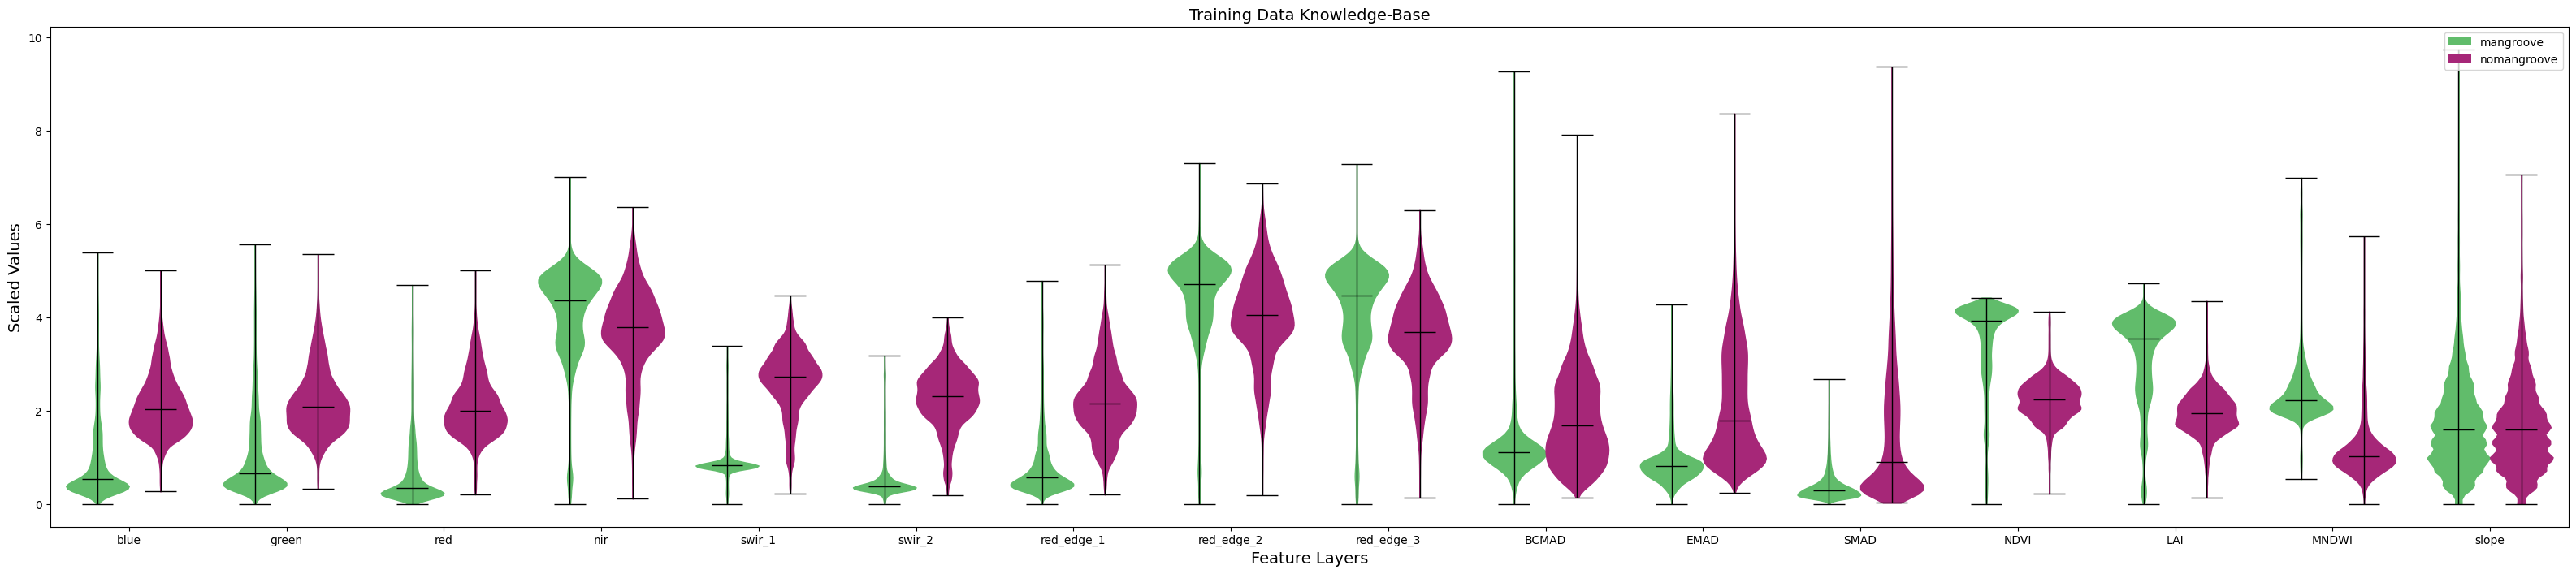

In [18]:
#generate a random list of colors same length as num of classes 
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(dfs))

#generate list of offsets & widths for plotting
start=-0.2 
end=0.2
offsets = list(np.linspace(start,end,len(dfs)))
if len(dfs) == 2:
    width=0.4
else:
    width=np.abs(offsets[0] - offsets[1])

#create figure and axes 
fig, ax = plt.subplots(figsize=(40,8))

for key, color, offset in zip(dfs,colors, offsets):
    #create violin plots
    pp = ax.violinplot(dfs[key].values,
                       showmedians=True,
                       positions=np.arange(dfs[key].values.shape[1])+offset, widths=width
                      )
    # change the colour of the plots
    for pc in pp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(1)
    
    #change the line style in the plots
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = pp[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

#tidy the plot, add a title and legend
ax.set_xticks(np.arange(len(column_names[1:])))
ax.set_xticklabels(column_names[1:])
ax.set_xlim(-0.5,len(column_names[1:])-.5)
ax.set_ylabel("Scaled Values", fontsize=14)
ax.set_xlabel("Feature Layers", fontsize=14)
ax.set_title("Training Data Knowledge-Base", fontsize=14)
ax.legend([Patch(facecolor=c) for c in colors], [key for key in dfs], loc='upper right');
plt.savefig("violin.png")

In [19]:
model=RandomForestClassifier(random_state=42)
model.fit(X, y.values.ravel());

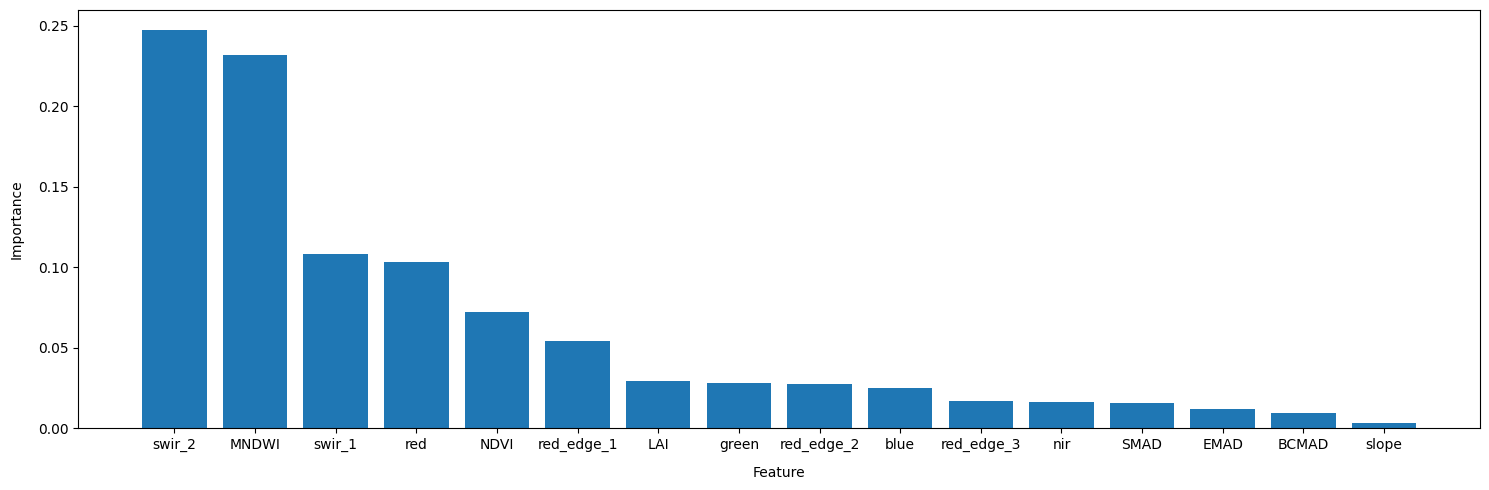

In [20]:
feature_names = ['blue', 'green', 'red', 'nir', 'swir_1', 'swir_2', 'red_edge_1', 'red_edge_2', 'red_edge_3', 'BCMAD', 'EMAD', 'SMAD', 'NDVI', 'LAI', 'MNDWI', 'slope']

order = np.argsort(model.feature_importances_)[::-1]  

plt.figure(figsize=(15,5))
plt.bar(x=np.array(feature_names)[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Feature', labelpad=10)
plt.tight_layout()
plt.savefig("FeatureImportnace.png")

In [21]:
DataFrame = pd.DataFrame(model_input,columns=column_names)
DataFrame

,class,blue,green,red,nir,swir_1,swir_2,red_edge_1,red_edge_2,red_edge_3,BCMAD,EMAD,SMAD,NDVI,LAI,MNDWI,slope
0,1.0,0.087530,0.078607,0.046134,0.715028,0.192095,0.090548,0.073835,0.707150,0.696793,0.071190,0.063440,0.033712,0.942941,0.848397,0.280835,0.185996
1,1.0,0.088729,0.081592,0.048733,0.705036,0.193258,0.092534,0.075269,0.700315,0.688880,0.076919,0.070150,0.033236,0.937286,0.837555,0.281876,0.185996
2,1.0,0.085132,0.073632,0.047433,0.689448,0.194130,0.095711,0.076703,0.681388,0.667638,0.089260,0.078979,0.036860,0.934120,0.824744,0.273658,0.191721
3,1.0,0.082734,0.081592,0.049383,0.665867,0.193839,0.095711,0.077419,0.681388,0.667638,0.094694,0.082120,0.034461,0.924777,0.801893,0.281082,0.191721
4,1.0,0.088729,0.095522,0.055231,0.654676,0.195583,0.099285,0.083154,0.666141,0.649729,0.086712,0.074063,0.036458,0.914700,0.787983,0.290812,0.191721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135141,0.0,0.258993,0.267662,0.278103,0.536371,0.559140,0.492851,0.298925,0.528917,0.498126,0.284274,0.324321,0.388100,0.633205,0.512478,0.111150,0.073521
135142,0.0,0.263789,0.268657,0.285250,0.520384,0.559140,0.493249,0.298925,0.527865,0.497293,0.275395,0.321170,0.357452,0.616966,0.493585,0.111652,0.092998
135143,0.0,0.266187,0.268657,0.252112,0.641487,0.524557,0.441223,0.306810,0.624606,0.598084,0.343705,0.477096,0.456389,0.712517,0.626360,0.129446,0.118550
135144,0.0,0.280576,0.280597,0.281352,0.602718,0.530660,0.454329,0.313262,0.590431,0.561849,0.375650,0.493668,0.509042,0.667107,0.570264,0.132337,0.118550


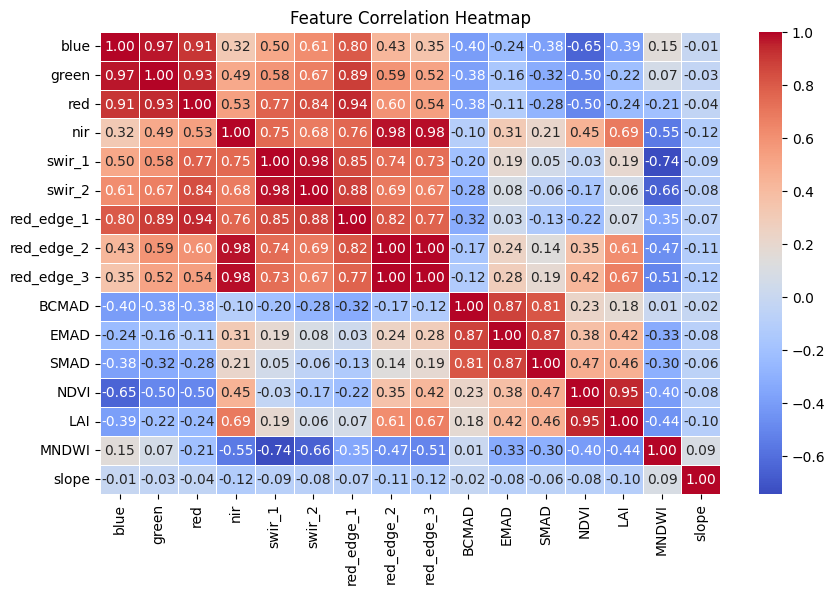

In [22]:
df_features =df.iloc[:,0:]
# Compute correlation matrix
correlation_matrix = df_features.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title
plt.title("Feature Correlation Heatmap")

plt.savefig("CorrelationHeatMap.png")
plt.show()


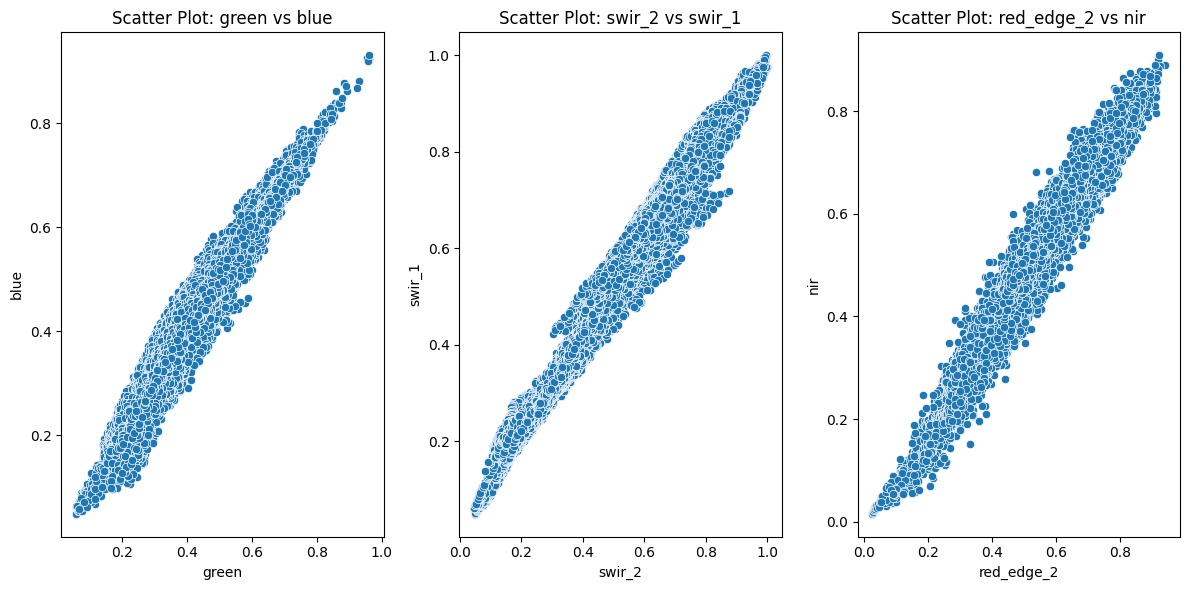

In [23]:

# Set threshold for high correlation 
threshold = 0.96

# Find pairs of highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):  # To avoid duplicate pairs and self-correlation
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Plot scatter plots for each highly correlated pair
plt.figure(figsize=(12, 6))
for idx, (feature1, feature2) in enumerate(high_corr_pairs[:3]):  # Plot up to 3 pairs
    plt.subplot(1, 3, idx + 1)
    sns.scatterplot(data=df, x=feature1, y=feature2)
    plt.title(f'Scatter Plot: {feature1} vs {feature2}')
plt.savefig("ScatterPlot.png")
plt.tight_layout()
plt.show()


In [24]:
DataFrame.columns

Index(['class', 'blue', 'green', 'red', 'nir', 'swir_1', 'swir_2',
       'red_edge_1', 'red_edge_2', 'red_edge_3', 'BCMAD', 'EMAD', 'SMAD',
       'NDVI', 'LAI', 'MNDWI', 'slope'],
      dtype='object')

In [25]:
# Define features and target
features = ['blue', 'green', 'red', 'nir', 'swir_1', 'swir_2',
       'red_edge_1', 'red_edge_2', 'red_edge_3', 'BCMAD', 'EMAD', 'SMAD',
       'NDVI', 'LAI', 'MNDWI', 'slope']
X = DataFrame[features]
y = DataFrame["class"]

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, classification_report

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [27]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.9922

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     10298
         1.0       0.99      0.99      0.99     16732

    accuracy                           0.99     27030
   macro avg       0.99      0.99      0.99     27030
weighted avg       0.99      0.99      0.99     27030



In [28]:
dump(model, 'RandonForest_model.joblib')

['RandonForest_model.joblib']

In [ ]:
# DataFrame.columns

In [ ]:
# DataFrame.groupby("Class").count()

In [ ]:
# noMangrove = DataFrame[DataFrame["Class"]==0]
# noMangrove

In [ ]:
# Mangrove =  DataFrame[DataFrame["Class"]==1]

In [29]:
# noMangrove.sample(n=5000)
# Mangrove.sample(n=9000)

# all_data=pd.concat([noMangrove,Mangrove])



NameError: name 'noMangrove' is not defined

In [ ]:
all_data.groupby("Class").count()

In [30]:
import datacube
import xarray as xr
from joblib import load
import matplotlib.pyplot as plt
from odc.geo.xr import write_cog

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.classification import predict_xr

import warnings
warnings.filterwarnings("ignore")


In [31]:
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/quinnkonya4@gmail.com/proxy/8787/status,
Dashboard: /user/quinnkonya4@gmail.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 11.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38859,Workers: 1
Dashboard: /user/quinnkonya4@gmail.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 11.21 GiB
Comm: tcp://127.0.0.1:41003,Total threads: 2
Dashboard: /user/quinnkonya4@gmail.com/proxy/38589/status,Memory: 11.21 GiB
Nanny: tcp://127.0.0.1:41139,


In [32]:
model_path = 'RandonForest_model.joblib'

testing_locations = {
    '1': (-2.191984600689281,
        40.925337842094734
          ),
   
}

buffer = 0.1

dask_chunks = {'x':1000,'y':1000}

results = 'results/'

In [33]:
model = load(model_path).set_params(n_jobs=1)

In [34]:
from datacube.testutils.io import rio_slurp_xarray

def feature_layers(query):
    #connect to the datacube
    dc = datacube.Datacube(app='feature_layers')
    
    #load ls8 geomedian
    ds = dc.load(product='gm_s2_annual',
                 **query)
    
    #calculate some band indices
    da = calculate_indices(ds,
                           index=['NDVI','LAI','MNDWI'],
                           drop=False,
                           satellite_mission='s2')
    
    #add slope dataset
    url_slope = "https://deafrica-input-datasets.s3.af-south-1.amazonaws.com/srtm_dem/srtm_africa_slope.tif"
    slope = rio_slurp_xarray(url_slope, gbox=ds.geobox)
    slope = slope.to_dataset(name='slope').chunk(dask_chunks)
    
    #merge results into single dataset 
    result = xr.merge([da, slope],compat='override')

    return result.squeeze()

In [35]:
# Set up the inputs for the ODC query
time = ('2019')
measurements =  ['blue','green','red','nir','swir_1','swir_2','red_edge_1',
                 'red_edge_2', 'red_edge_3', 'BCMAD', 'EMAD', 'SMAD']
resolution = (-20,20)
output_crs='epsg:6933'

In [36]:
predictions = []

for key, value in testing_locations.items():
    
    print('working on: ' + key)

     # generate a datacube query object
    query = {
        'x': (value[1]-buffer, value[1]+buffer),
        'y': (value[0]+buffer, value[0]-buffer),
        'time': time,
        'measurements': measurements,
        'resolution': resolution,
        'output_crs': output_crs,
        'dask_chunks' : dask_chunks,
    }

    #calculate features
    data = feature_layers(query)

    #predict using the imported model
    predicted = predict_xr(model,
                           data,
                           proba=True,
                           persist=True,
                           clean=True,
                           return_input=True
                          ).compute()
        
    predictions.append(predicted)
    

working on: 1
predicting...


/opt/venv/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


   probabilities...
   input features...


/opt/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


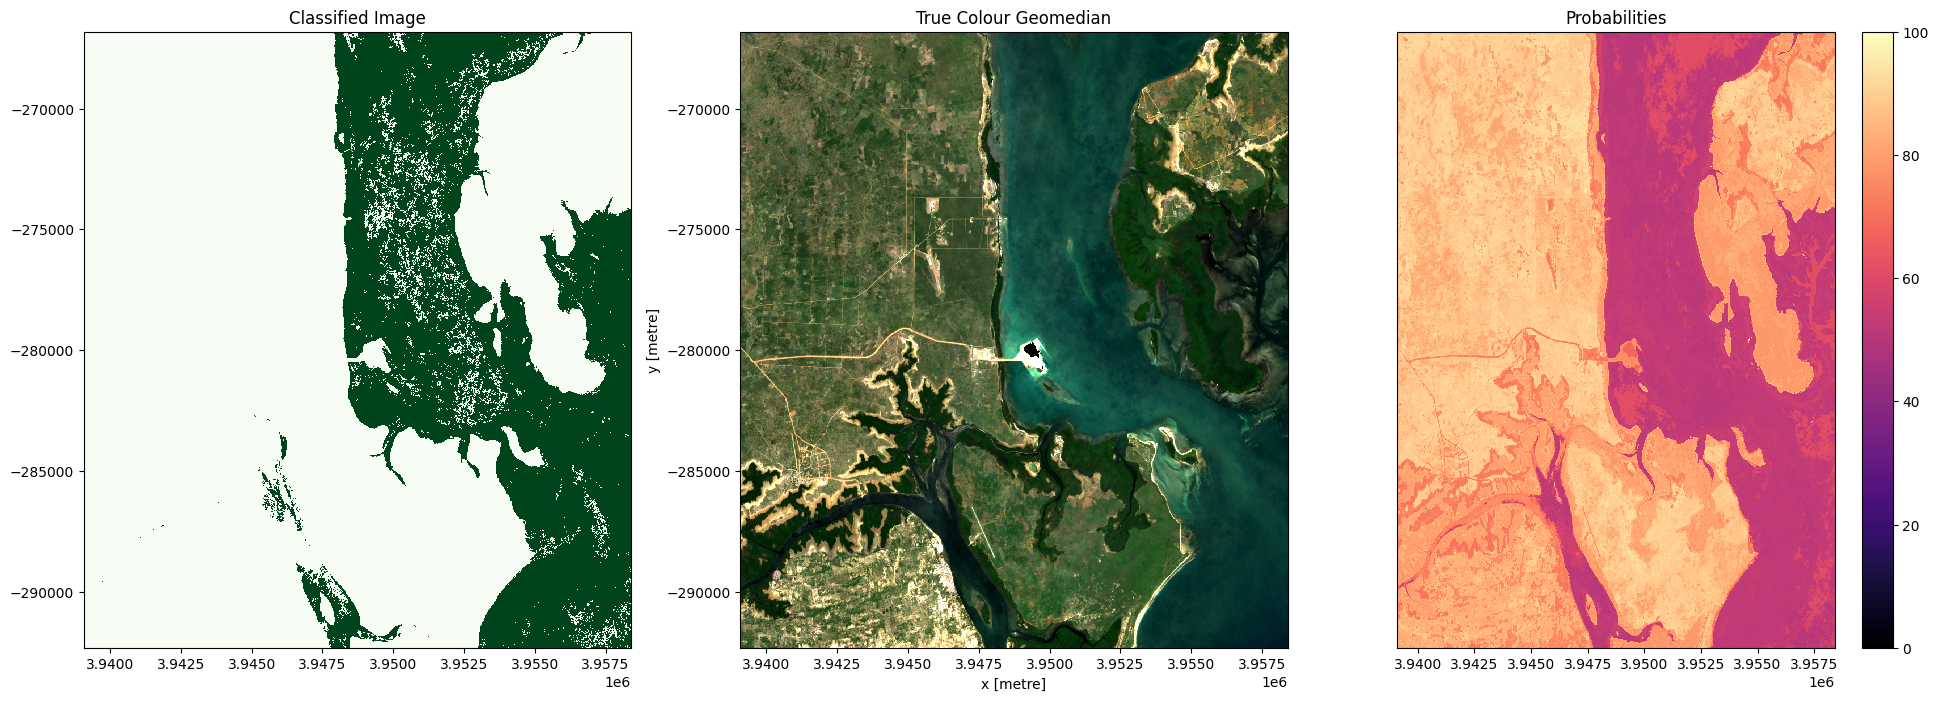

In [37]:
for i in range(0, len(predictions)):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))


    # Plot classified image
    predictions[i].Predictions.plot(ax=axes[0], 
                   cmap='Greens', 
                   add_labels=False, 
                   add_colorbar=False)

    # Plot true colour image
    rgb(predictions[i], bands=['red','green','blue'],
        ax=axes[1], percentile_stretch=(0.01, 0.99))

    predictions[i].Probabilities.plot(ax=axes[2], 
                   cmap='magma',
                   vmin=0,
                   vmax=100,
                   add_labels=False, 
                   add_colorbar=True)

    # Remove axis on right plot
    axes[2].get_yaxis().set_visible(False)

    # Add plot titles
    axes[0].set_title('Classified Image')
    axes[1].set_title('True Colour Geomedian')
    axes[2].set_title('Probabilities');